![Py4Eng](img/logo.png)

# Approximate Bayesian Computation
## Yoav Ram

In [42]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
import seaborn as sns
from scipy.stats import norm, poisson, uniform, halfnorm
from corner import corner 
import pyabc
import networkx as nx
sns.set_context('talk')

red, blue, green, purple, orange = sns.color_palette('Set1', 5)

# Bayesian inference

*Reminder:* Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. 

**Bayes' theorem**.
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ are the model parameters
- $X$ are the data
and we have
$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the *prior probability* that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the *likelihood of $\theta$*
- $P(\theta \mid X)$ is called the *posterior probability*, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

But what happens if we cannot write or even compute the likelihood function $P(X \mid \theta)$?

The family of methods that try to resolve this problem are called **likelihood free inference** methods, and the most common one is approximate Bayesian computation, or ABC.

# Approximate Bayesian computation

ABC is a likelihood-free method of Bayesian inference that uses simulation to approximate the posterior distribution of the model parameters. 
It is used where
- the likelihood function is unknown or is too computationally expensive to compute, and
- there exists a good _forward model_ that can produce data sets like the one of interest.

It is not a replacement for other methods when a likelihood function is available (depsite the example we use in this lecture)!

**Reminder:** in MCMC sampling used in Bayesian inference when the likelihood is known, the algorithm follows these steps:

At iteration $i$, given the previous parameter value $\theta_i$, we
1. Generate a candidate parameter value $\theta^*$ from a proposal distribution $\theta^* \sim N(\theta_i, \eta)$.
1. Compute the likelihood $P(X \mid \theta^*)$.
1. Set the acceptance probability $\alpha = \frac{P(\theta^* \mid X)}{P(\theta_i \mid X)} = \frac{P(X \mid \theta^*)P(\theta^*)}{P(X \mid \theta_i)P(\theta_i)}$ to the ratio of posterior probabilities.
1. Set $\theta_{i+1} = \theta^*$ with probability $min(1,\alpha)$ (i.e. accept $\theta^*$), otherwise set $\theta_{i+1} = \theta_i$ (i.e. reject $\theta^*$ and keep $\theta_i$ again).

In ABC, we cannot compute the likelihood $P(X \mid \theta)$.
But, we can sample from the distribution that this likelihood represents using a simulator: $f(X) \sim P(X \mid \theta)$.

We can then compare the simulated $X'$ and the observed $X$ to conclude if $\theta$ is likely -- thereby approximating the likelihood of $\theta$ without directly computing it.

![ABC](img/ABC.png)
from [Cranmer et al, 2020](http://www.pnas.org/lookup/doi/10.1073/pnas.1912789117)

What do we need for ABC?

- we need a simulator $f(\theta)$ that samples from a distribution that approximates the likelihood function, that is $P(f(\theta)=X) P(X \mid \theta)$.
- we need a good way (???) to summarize the data $S(X)$,
- we need a good way (???) to measure the distance between two summaries $\rho(S(X'), S(X))$, and
- we need a good way (???) to decide if the measured distance is small enough to accept the parameters that generated it.

# Photon count model

We use the "complex" photon count model that we have seen before.

the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expectation ($F_i$) changes over time -- it is drawn from a normal distrubtion with expectation $\mu$ and standard deviation $\sigma$:
$$
F_i \sim N(\mu, \sigma) \\
X_i \sim Poi(F_i)
$$

We note the model parameters as $\theta = (\mu, \sigma)$.

In [14]:
# for reproducibility
np.random.seed(42)
n = 100  
θ = (μ, σ) = 1000, 15
F = norm(μ, σ).rvs(size=n)
X = poisson(F).rvs()

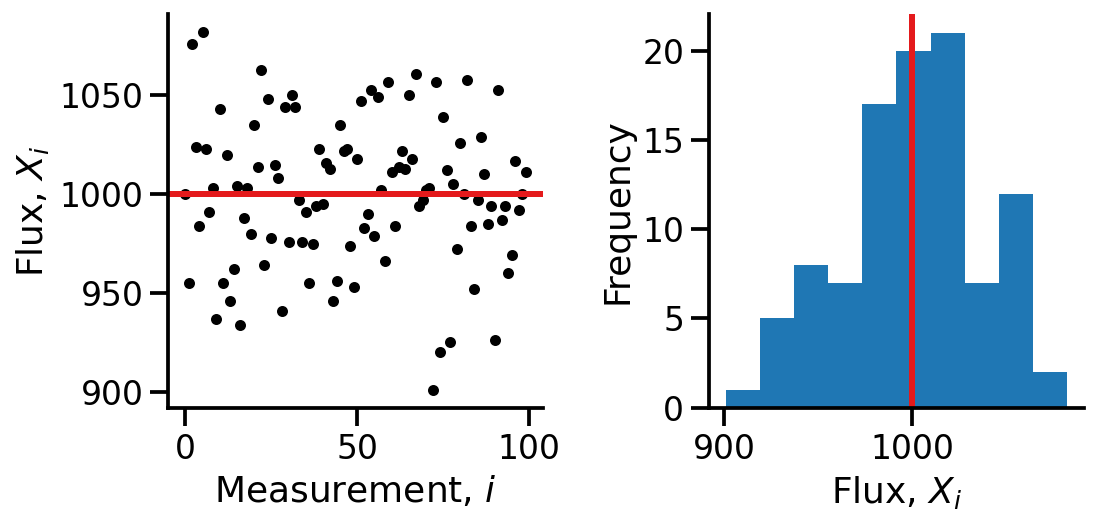

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Flux, $X_i$")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux, $X_i$")

fig.tight_layout()
sns.despine()

## Rejection sampling with NumPy

Given empirical data $X$, a model parameterized by the vector $\theta$, and a simulation $f(\theta)$ that implements the model and generates simulated data $X'$, the following describes the *rejection sampling algorithm*:

1. Generate candidate parameter value from the prior $\theta^* \sim P(\theta)$  
1. Generate data from the simulation $X^* = f(\theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(X^*), S(X))$
1. Accept $\theta^*$ if $\rho^* \le \epsilon$.

The collection of accepted $\theta^*$ values approximates the posterior distribution $P(\theta \mid X)$; the smaller $\epsilon$ is, the better the approximation.

How do we set $\epsilon$?
In this case, we looked at the plot to get some intuition. 
If we don't have an intuition, we can take the best 1% or 5% of samples.
The problem is that the acceptance rate can be very low.
We'll deal with that in the next section.

We will use a weak prior:
$$
\mu \sim \mathit{Normal}(990, 10) \\
\sigma \sim \mathit{HalfNormal}(\mu=0, \sigma=50)
$$

We also use a half-normal distribution for $\sigma$ (see [Gelman 2006](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf) for a discussion about priors for variance parameters).


In [16]:
N = 100000

μ_prior = norm(990, 10)
σ_prior = halfnorm(0, 50)
μs = μ_prior.rvs(size=N)
σs = σ_prior.rvs(size=N)

def log_prior(μ, σ):
    return (μ_prior.logpdf(μ) + σ_prior.logpdf(σ)).sum()

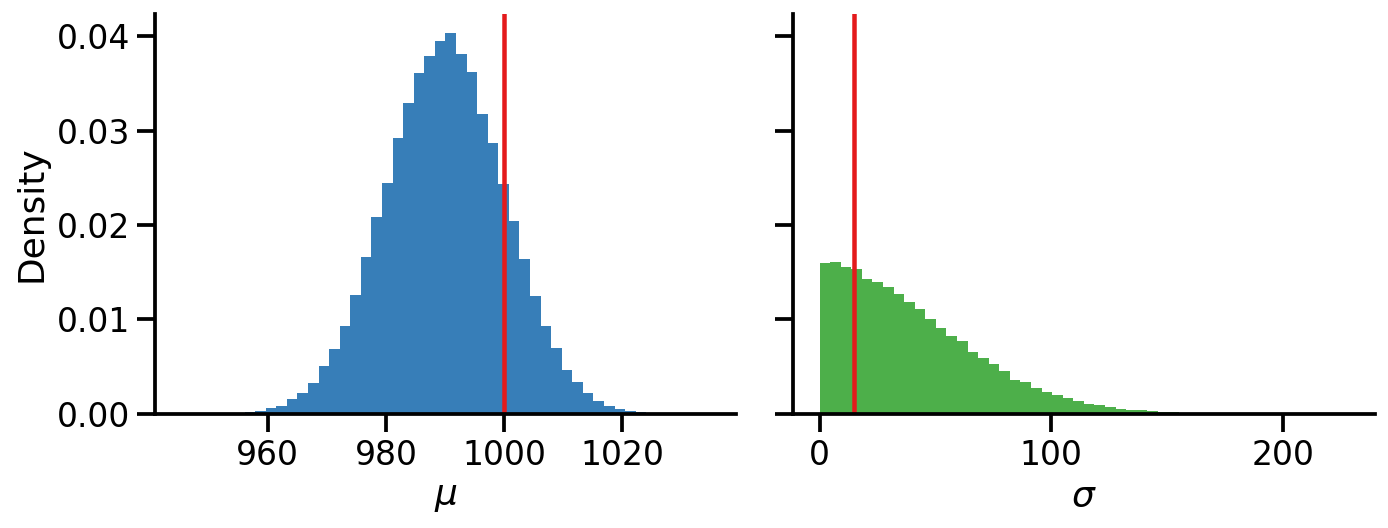

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(μs, bins=50, color=blue, density=True)
axes[0].axvline(μ, color=red)
axes[1].hist(σs, bins=50, color=green, density=True)
axes[1].axvline(σ, color=red)
axes[0].set(xlabel='$\mu$', ylabel='Density')
axes[1].set(xlabel='$\sigma$')
fig.tight_layout()
sns.despine()

We need a simulator, a summary, and a distance.

For summaries, we will use the mean and standard deviation.

$$
S_1(X) = \frac{1}{n}\sum_{i=1}^{n}{X_i} \\
S_2(X) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(X_i - S_1(X))^2}} \\
$$

The distance function will be the absolute distance:
$$
\rho(X', X) = \big|S_1(X')-S_1(X)\big| + \big|S_2(X')-S_2(X)\big|
$$

Note that these functions expect a 2D array with shape `(experiments, samples)`; the idea is to use NumPy array operations to compute many simulations, summaries, and distances together.

In [18]:
def simulator(μ, σ, n=1):
    """μ, σ: parameters
       n: number of samples
    """
    μ, σ = np.atleast_1d(μ, σ) # is scalar convert to 1d
    F = norm(μ, σ).rvs(size=(n, μ.size)) # shape (n, N)
    X_sim = poisson(np.maximum(F, 0)).rvs()
    return X_sim.T # shape (N, n)

def summary(X):
    X = np.atleast_2d(X) # shape (N, n)
    S1 = X.mean(axis=1) # over n
    S2 = X.std(axis=1, ddof=1) # over n
    return np.array([S1, S2]) # shape (2, N)

def distance(S_sim, S):
    diff = S - S_sim
    absdiff = np.abs(diff)
    return absdiff.sum(axis=0) # sum over summaries, shape (N)

In [19]:
X_sim = simulator(μs, σs, n)
assert X_sim.shape == (N, n)
S = summary(X)
S_sim = summary(X_sim)
assert S_sim.shape == (2, N)
ρs = distance(S_sim, S)
assert ρs.shape == (N,)

We can take a look at what we got.

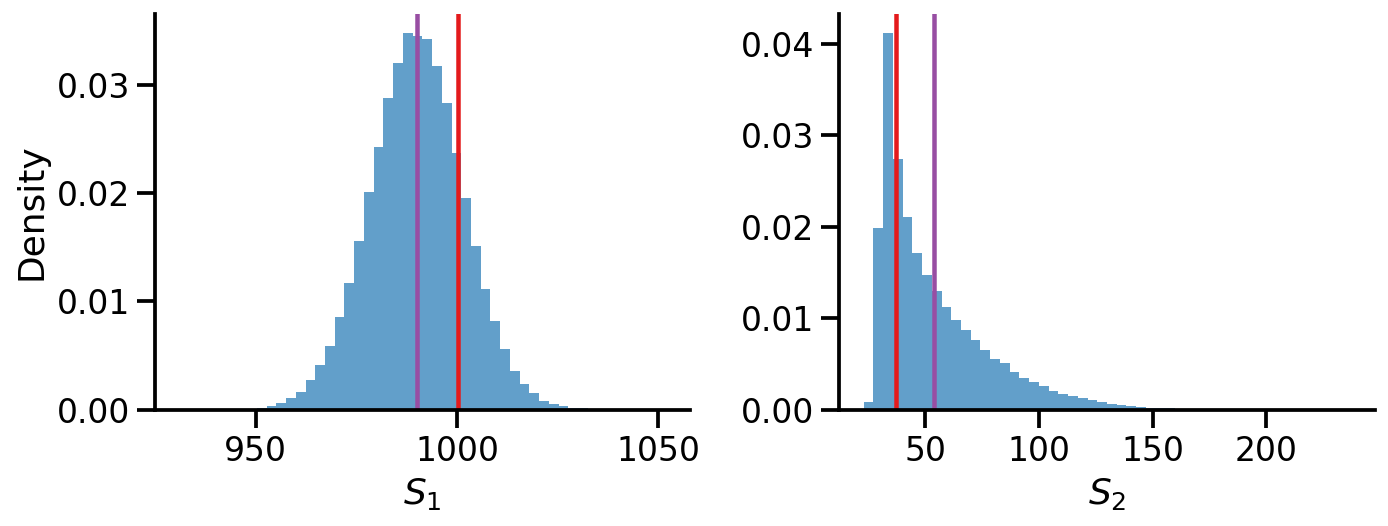

In [20]:
S1, S2 = S # S is shape (2,1)
S1_sim, S2_sim = S_sim # S_sim is shape (2,N)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.hist(S1_sim, bins=50, alpha=0.7, density=True)
ax.axvline(S1, color=red)
ax.axvline(S1_sim.mean(), color=purple)
ax.set_xlabel(r"$S_1$")
ax.set_ylabel("Density")
ax = axes[1]
ax.hist(S2_sim, bins=50, alpha=0.7, density=True)
ax.axvline(S2, color=red)
ax.axvline(S2_sim.mean(), color=purple)
ax.set_xlabel(r"$S_2$")
fig.tight_layout()
sns.despine()

As for the distances, lets look at the standardized distance (distance divided by the standard deviation).

The plot shows the distance function for all the simulations (blue and green).
The red line shows the real parameter values.
The black line shows the value $\epsilon$, which is a threshold that accepts 10% of the samples.

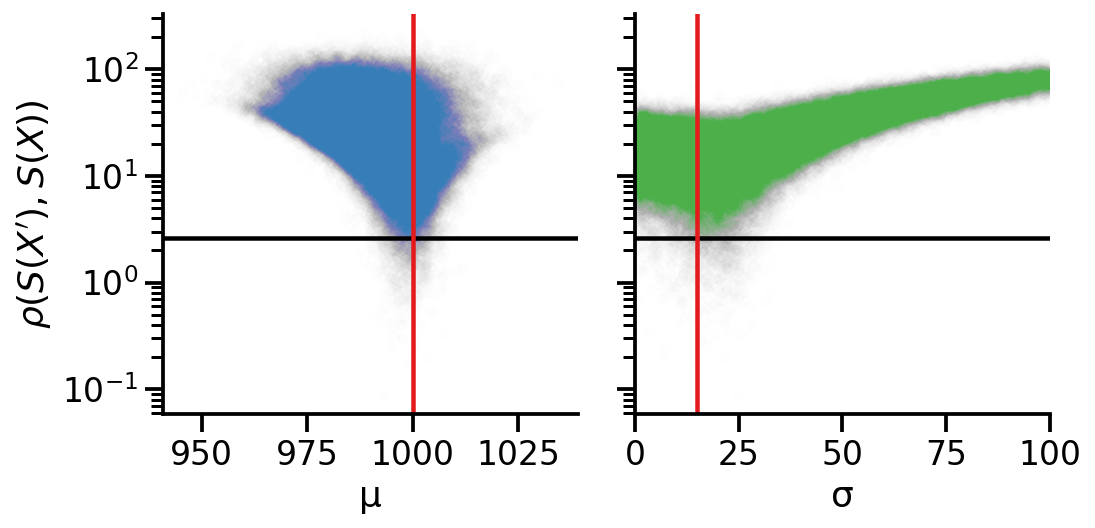

In [21]:
quantile = 0.01
ϵ = np.quantile(ρs, quantile)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plot_kws = dict(marker='.', ls='', alpha=0.002)
                  
ax = axes[0]
ax.plot(μs, ρs, color=blue, **plot_kws)
ax.axhline(ϵ, color='k')
ax.axvline(μ, color=red)
ax.set(xlabel='μ', yscale='log', ylabel=r"$\rho(S(X'), S(X))$")

ax = axes[1]
ax.plot(σs, ρs, color=green, **plot_kws)
ax.axhline(ϵ, color='k')
ax.axvline(σ, color=red)
ax.set(xlabel='σ', xlim=(0, 100))

fig.tight_layout()
sns.despine()

We now accept and reject.

In [22]:
idx_accepted = ρs < ϵ
print("Accepted {} ({:.2%}) of {} generated samples".format(
    idx_accepted.sum(), idx_accepted.mean(), idx_accepted.size))
μs_accepted = μs[idx_accepted]
σs_accepted = σs[idx_accepted]

Accepted 1000 (1.00%) of 100000 generated samples


We now treat the accepted parameter samples as an approximate to the posterior distribtion:

In [23]:
μ_hat, σ_hat = μs_accepted.mean(), σs_accepted.mean()

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 998.92
σ = 15		σ_hat = 17.51


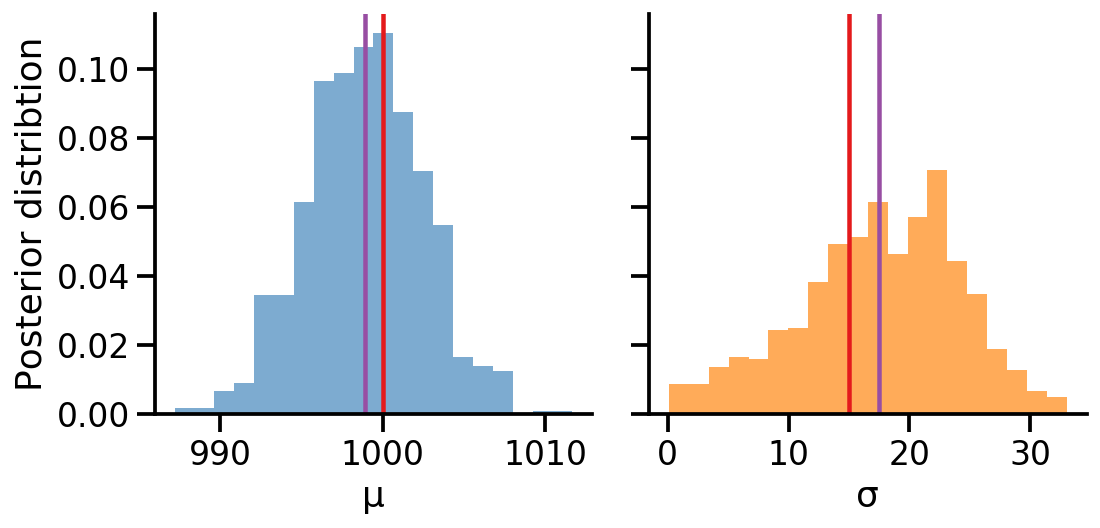

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
hist_kws = dict(bins=20, density=True, alpha=0.65)

ax = axes[0]
ax.hist(μs_accepted, color=blue, **hist_kws)
ax.axvline(μ, color=red)
ax.axvline(μs_accepted.mean(), color=purple)
ax.set(xlabel='μ', ylabel='Posterior distribtion')

ax = axes[1]
ax.hist(σs_accepted, color=orange, **hist_kws)
ax.axvline(σ, color=red)
ax.axvline(σs_accepted.mean(), color=purple)
ax.set(xlabel='σ')

fig.tight_layout()
sns.despine()

The black and red lines are the real and point-estimates of the parameters.
Its OK, but not that good.

## MCMC sampling

A common sampler that deals with the inefficiency of the rejection sampler is the Markov chain Monte Carlo (MCMC) sampler, which creates chains of accepted parameter samples of length $N$ using the algorithm:

1. Initiaize $\theta_1$, $i=1$.
1. Generate a candidate parameter value $\theta^* \sim q(\theta \mid \theta_i) = N(\theta_i, \eta)$.
1. Generate data from the simulator $X^* = f(\theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(X^*), S(X))$ using the summary $S(X)$.
1. If $\rho^* \le \epsilon$, set the acceptance probability $\alpha=\min{\Big(1, \frac{P(\theta^*)}{P(\theta_i)}\Big)}$. 
1. Otherwise set it to $\alpha=0$.
1. Accept $\theta_{i+1}=\theta^*$ with probability $\alpha$ and $\theta_{i+1}=\theta_i$ with probability $(1-\alpha)$.
1. If $i<N$, increment $i = i + 1$ and go to step 2.

This sampling algorithm is much more efficient than the rejection sampling, as it is able to "spend more time" in areas of high likelihood.

However, this algorithm can get stuck on areas of low likelihood.

In the simulation step, it is possible to simulate multiple simulations and summarize all of them. This will leverage NumPy array operations for increased efficiency and precision.

A nice example of using MCMC for ABC is presented in
> 1. Tanaka MM, Francis AR, Luciani F, Sisson SA. [Using approximate bayesian computation to estimate tuberculosis transmission parameters from genotype data](http://doi.org/10.1534/genetics.106.055574). Genetics. 2006;173(3):1511-1520. doi:10.1534/genetics.106.055574

## Sequential Monte Carlo sampling with pyABC

Sequential Monte Carlo sampler (SMC) is a more advanced Monte Carlo method that uses a different approach then MCMC.

Briefly, SMC creates a population of parameter samples ("particles"), and performs a series of steps similar to MCMC to move them around the parameter space. 
After a while it, it creates a new population from the samples that have distance less than $\epsilon$. It continues with the new population, and decreases $\epsilon$. 
The final population has a very low $\epsilon$, but the acceptance rate is higher than it would be in the rejection sampler with the same low $\epsilon$.
By using the particles that were accepted in the previous iteration to propose particles for the next iteration, we sample from an increasingly better approximation of the posterior, which allows to decrease epsilon while keeping good acceptance rates.

This sampler has several advantages -- an adaptive acceptance rate ($\epsilon$), independent sampling of parameters, computational efficiency, and more.
For details on the SMC sampler in ABC and a comparison to rejection and MCMC sampling, see:

> Sisson SA, Fan Y, Tanaka MM (2007) [Sequential Monte Carlo without likelihoods](http://doi.org/10.1073/pnas.0607208104). Proc Natl Acad Sci 104(6):1760–1765.

[pyABC](https://pyabc.readthedocs.io/) is a Python package that implements the Sequential Monte Carlo sampler (SMC).

We start with the priors
$$
\mu \sim \mathit{Normal}(990, 10) \\
\sigma \sim \mathit{HalfNormal}(\mu=0, \sigma=50)
$$
The distributions are named and parameterized exactly as they do in `scipy.stats`.

In [24]:
priors = pyabc.Distribution(
    μ=pyabc.RV("norm", 990, 10),
    σ=pyabc.RV("halfnorm", 0, 50)
)
priors.rvs()

<Parameter 'μ': 980.6617848643119, 'σ': 47.08220895520828>

We define a model function that takes a `dict` of parameters and returns a `dict` of summaries. The summaries in this case are the mean of `n` samples.

In [25]:
def model(parameters):
    X = simulator(parameters['μ'], parameters['σ'], n=n) # shape N,n
    S1, S2 = summary(X).squeeze() # shape 2,N
    return dict(
        S1=S1,
        S2=S2
    )
model(priors.rvs())

{'S1': 975.71, 'S2': 69.78557273259396}

We define a distance function that takes two `dict`s of summaries -- a simulation and an observation -- and returns the distance.

Here we just add the summary distances. But they do have different ranges of values.
A better approach is to weight them is some way, this can be done automatically in [pyABC with adaptive distances](https://pyabc.readthedocs.io/en/latest/examples/adaptive_distances.html).

In [26]:
def distance_(simulation, data):
    return (
        np.abs(data['S1'] - simulation['S1']) +
        np.abs(data['S2'] - simulation['S2'])
    )[0] # if you dont do [0] it will return an array and abc will fail

observation = dict(
    S1=S[0],
    S2=S[1]
)
distance_(model(priors.rvs()), observation)

36.662808226770764

We setup the sampler.

In [27]:
abc = pyabc.ABCSMC(
    model, 
    priors, 
    distance_,
    population_size=1000, 
    # you can try to remove the next line and see if multicore sampler (the default) works
    sampler=pyabc.SingleCoreSampler()
)

We save everything to a sqlite file so we can load it later if we want.

In [28]:
db_path = "sqlite:///pyabc_photon_count.db"

In [29]:
history = abc.new(db_path, observation);

INFO:History:Start <ABCSMC(id=5, start_time=2020-11-03 21:24:51.345736, end_time=None)>


We run it until we get the same $\epsilon$ that we used with the rejection sampler, which we picked to get 1% acceptance rate, using 100,000 simulations to get 1,000 samples.

In [30]:
history = abc.run(minimum_epsilon=ϵ)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 25.051791097359306
INFO:ABC:t: 0, eps: 25.051791097359306.
INFO:ABC:Acceptance rate: 1000 / 1926 = 5.1921e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 14.311341933683329.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.7049e+02.
INFO:ABC:t: 2, eps: 8.955401357552482.
INFO:ABC:Acceptance rate: 1000 / 2421 = 4.1305e-01, ESS=8.9892e+02.
INFO:ABC:t: 3, eps: 6.0976976760080746.
INFO:ABC:Acceptance rate: 1000 / 3371 = 2.9665e-01, ESS=7.7733e+02.
INFO:ABC:t: 4, eps: 4.387134423847705.
INFO:ABC:Acceptance rate: 1000 / 5276 = 1.8954e-01, ESS=6.9182e+02.
INFO:ABC:t: 5, eps: 3.1733153098278293.
INFO:ABC:Acceptance rate: 1000 / 8571 = 1.1667e-01, ESS=6.9411e+02.
INFO:ABC:t: 6, eps: 2.193765316214239.
INFO:ABC:Acceptance rate: 1000 / 14721 = 6.7930e-02, ESS=5.8691e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=5, start_time=2020-11-03 21:24:51.345736, end_time=2020-11-03 21:26:31.527099)>


We needed 100,000 simulations with rejection sampling. 
They were pretty fast to run, but that was because they were very simple and we could vectorise them with NumPy.
In general, simulations may be quite slow so we want to run as few as possible.

SMC got 1,000 samples with the same $\epsilon$ by running this many simulations:

In [32]:
abc.load(db_path, history.id) # load from file using the history id
history = abc.history

history.total_nr_simulations

39391

Note that because SMC uses importance sampling, the final 1,000 samples need to be weighted accordingly, so we need to compute the weighted mean rather than the regular mean.

The point estimates are are pretty good.

In [33]:
samples, weights = history.get_distribution(m=0)
μ_sample, σ_sample = samples['μ'], samples['σ']
μ_hat, σ_hat = np.average(μ_sample, weights=weights), np.average(σ_sample, weights=weights)

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 999.03
σ = 15		σ_hat = 18.05


The posterior distribution plot - red for truth, purple for estimate. 
Again, we need to specify the weights.

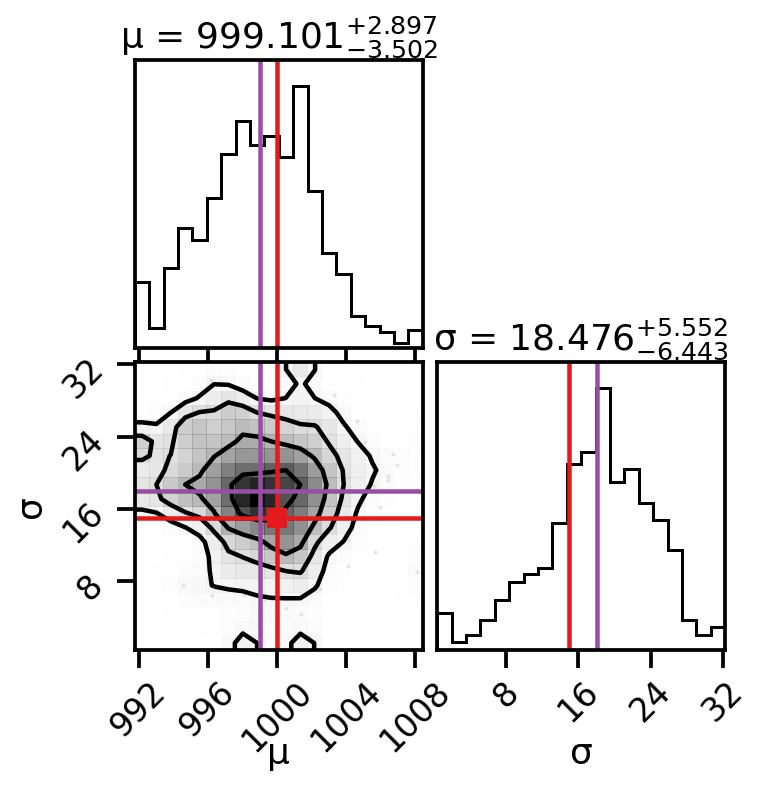

In [36]:
cor = corner(samples, 
    weights=weights,
    title_fmt='.3f', 
    smooth=True,
    show_titles=True,
    truths=(μ, σ),
    truth_color=red
)
cor.axes[0].axvline(μ_hat, color=purple)
cor.axes[3].axvline(σ_hat, color=purple)
cor.axes[2].axvline(μ_hat, color=purple)
cor.axes[2].axhline(σ_hat, color=purple);

## Posterior distribution convergence

The following shows how the joint posterior converged over the iterative populations of the SMC sampler.

It seems like the posterior didn't change much in the last population, so it is good we stopped.

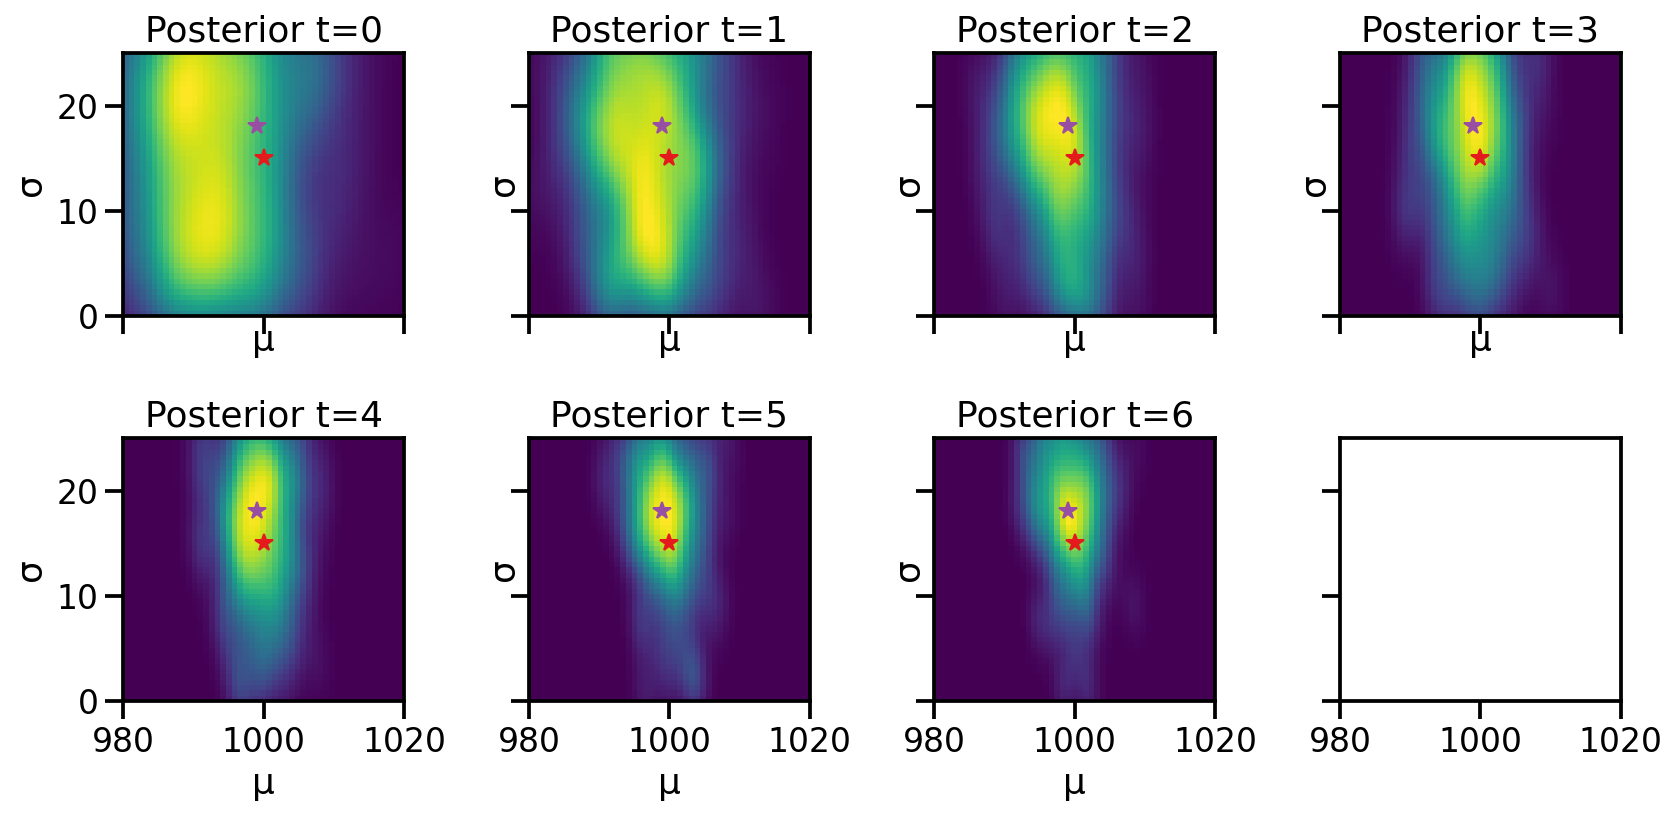

In [43]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for t in range(history.max_t + 1):
    ax = axes.flat[t]
    samples_, weights_ = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_2d(
        samples_, weights_, "μ", "σ",
        xmin=980, xmax=1020, ymin=0, ymax=25, colorbar=False, ax=ax)
    ax.plot(μ, σ, '*', color=red)
    ax.plot(μ_hat, σ_hat, '*', color=purple)
    ax.set_title("Posterior t={}".format(t))
fig.tight_layout()

# Dolphins social network model

We follow the analysis from a [paper on animal social networks](https://www.nature.com/articles/ncomms12084)
> Ilany A, Akçay E (2016) Social inheritance can explain the structure of animal social networks. Nat Commun 7(May). doi:10.1038/ncomms12084.

To work with graphs and networks we use [NetworkX](https://networkx.github.io), and we require at least version 2.

In [49]:
def show_net(network):
    G = nx.from_numpy_array(network)
    nx.draw_spring(G, node_color='#4466ee', alpha=0.8)

We download the dolphins data from [KONECT](http://konect.uni-koblenz.de/networks/dolphins); this site has a bunch of network data.

Now load the data and convert it to NumPy adjacency matrix.

In [50]:
dolphin_data = np.loadtxt('../data/out.dolphins', comments='%', dtype=int)
dolphin_data[:5]

array([[ 9,  4],
       [10,  6],
       [10,  7],
       [11,  1],
       [11,  3]])

The adjacency matrix $A_{i,j}$ is 1 if dolphins $i$ and $j$ are "friends", and 0 otherwise.
"friends" are dolphins that interact in the same vicinity, or that have been observed together.

In [51]:
N = dolphin_data.max() # dolphin ids go from 1 to 62
dolphin_network = np.zeros((N, N), dtype=int)
for row in dolphin_data:
    src, dst = row
    # to zero count
    src -= 1
    dst -= 1
    # set connection
    dolphin_network[dst, src] = 1
    dolphin_network[src, dst] = 1

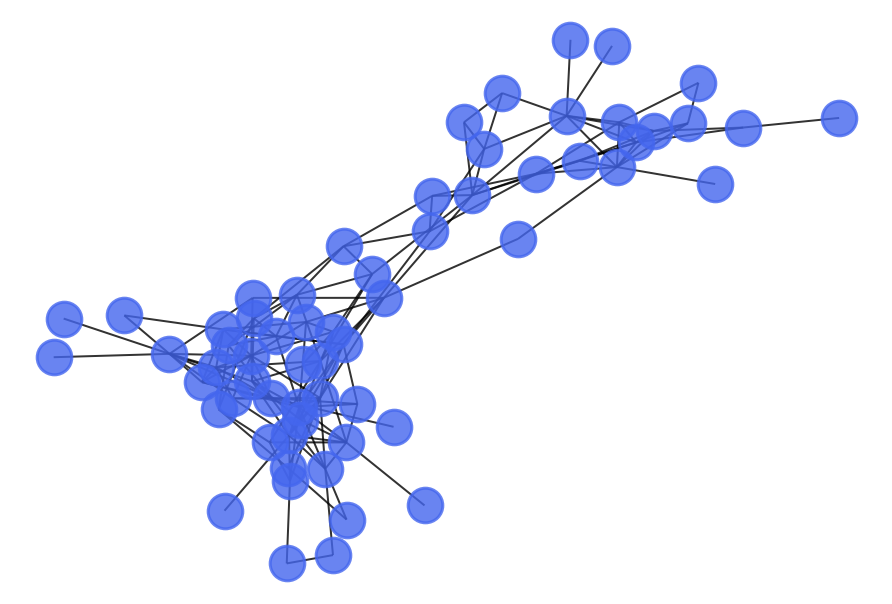

In [52]:
show_net(dolphin_network)

## Model and simulation

We model the development of a dolphin social network as in section _Simulation process_ of the paper by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084).

For the initial networks, use the [Erdos-Renyi random network generator](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html); [read more on these random graphs](https://en.wikipedia.org/wiki/Erdős–Rényi_model).

In [53]:
def simulator(pn, pr):       
    tmax = 20 * N
    deaths = np.random.randint(0, N, size=tmax)
    parents = np.random.randint(0, N, size=tmax)
    randoms = np.random.random(size=(tmax, N))

    G = nx.erdos_renyi_graph(N, p=0.1/2)
    network = nx.to_numpy_array(G, dtype=bool) # only in networkx 2
    
    for t in range(tmax):
        d = deaths[t]
        b = parents[t]
        network[d, :] = False
        network[:, d] = False
        moms_friends = network[b, :]
        rand = randoms[t, :]
        from_mom = moms_friends & (rand < pn)
        from_random = ~moms_friends & (rand < pr)
        network[d, :] = from_mom | from_random 
        network[d, b] = True
        network[:, d] = network[d, :]

    return network

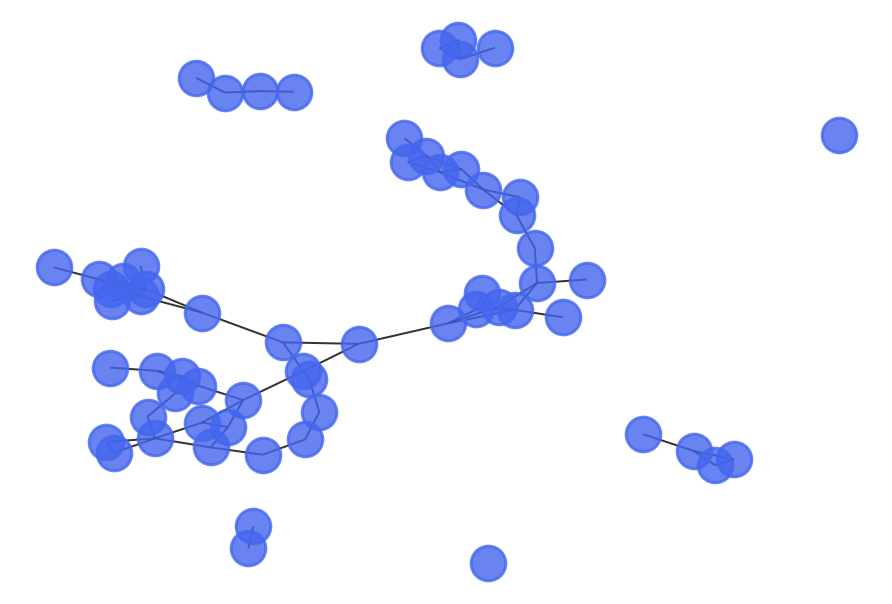

In [54]:
network = simulator(0.5, 0.01)
show_net(network)

## Summaries

We calculate the summary statistics, which are the mean degree of network nodes, and the clustering coefficient. 
- Degree of a node is the number of edges connected to it.
- Clustering coefficient of a node is the fraction of possible triangles through that node that exist, that is $\frac{2 T(u)}{deg(u)(deg(u)-1)}$, where $T(u)$ is the number of triangles passing through the node and $deg(u)$ is the node degree.

In [55]:
def mean_degree(network):
    degrees = network.sum(axis=0)
    return degrees.mean()

def clustering_coefficient(network):
    G = nx.from_numpy_matrix(network)
    clustering = nx.algorithms.clustering(G)
    return (np.fromiter(clustering.values(), dtype=float)).mean()

These are the summaries for the real network.

In [56]:
print("Mean degree {:.2f} \nClustering coefficient {:.2f}".format(
    mean_degree(dolphin_network),
    clustering_coefficient(dolphin_network)
))

Mean degree 5.13 
Clustering coefficient 0.26


In comparison, these are the summaries for a simulated network.

In [57]:
network = simulator(0.5, 0.01)
print("Mean degree {:.2f} \nClustering coefficient {:.2f}".format(
    mean_degree(network),
    clustering_coefficient(network)
)) 

Mean degree 2.84 
Clustering coefficient 0.36


## Inference with SMC

Now we'll use SMC-ABC to estimate the model parameters $p_n$ and $p_r$.
We set an uninformative prior $U(0,1)$ on both $p_n$ and $p_r$.
Otherwise we follow the same steps as above.

In [58]:
priors = pyabc.Distribution(
    pn=pyabc.RV("uniform", 0, 1),
    pr=pyabc.RV("uniform", 0, 1)
)
priors.rvs()

<Parameter 'pn': 0.6977964869262683, 'pr': 0.29587856524808576>

In [59]:
def model(parameters):
    network = simulator(parameters['pn'], parameters['pr'])
    return dict(
        mean_degree=mean_degree(network),
        clustering_coefficient=clustering_coefficient(network)
    )
model(priors.rvs())

{'mean_degree': 38.54838709677419,
 'clustering_coefficient': 0.6163911964466752}

In [60]:
def distance(simulation, data):
    return (
        np.abs(data['mean_degree'] - simulation['mean_degree']) +
        np.abs(data['clustering_coefficient'] - simulation['clustering_coefficient'])
    )

observation = dict(
    mean_degree=mean_degree(dolphin_network),
    clustering_coefficient=clustering_coefficient(dolphin_network)
)
distance(model(priors.rvs()), observation)

13.21320372002307

In [61]:
abc = pyabc.ABCSMC(
    model, 
    priors, 
    distance,
    population_size=1000,
    sampler=pyabc.SingleCoreSampler()
)
db_path = "sqlite:///pyabc_dolphin_network.db"

In [62]:
history = abc.new(db_path, observation)

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-03 21:30:53.275334, end_time=None)>


This time we are not comparing to a rejection sampler, so let's just stop the sampler when the acceptance rate is 5%.

In [63]:
history = abc.run(min_acceptance_rate=0.05)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 26.918943518880898
INFO:ABC:t: 0, eps: 26.918943518880898.
INFO:ABC:Acceptance rate: 1000 / 1965 = 5.0891e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 17.177998999904048.
INFO:ABC:Acceptance rate: 1000 / 2095 = 4.7733e-01, ESS=9.4004e+02.
INFO:ABC:t: 2, eps: 9.016478187809295.
INFO:ABC:Acceptance rate: 1000 / 2189 = 4.5683e-01, ESS=9.4212e+02.
INFO:ABC:t: 3, eps: 3.6493382161632137.
INFO:ABC:Acceptance rate: 1000 / 2052 = 4.8733e-01, ESS=9.4540e+02.
INFO:ABC:t: 4, eps: 1.9020929868298888.
INFO:ABC:Acceptance rate: 1000 / 1924 = 5.1975e-01, ESS=9.5175e+02.
INFO:ABC:t: 5, eps: 0.9937474481724694.
INFO:ABC:Acceptance rate: 1000 / 2157 = 4.6361e-01, ESS=9.1101e+02.
INFO:ABC:t: 6, eps: 0.5610679785574771.
INFO:ABC:Acceptance rate: 1000 / 2780 = 3.5971e-01, ESS=8.9866e+02.
INFO:ABC:t: 7, eps: 0.3391324334966825.
INFO:ABC:Acceptance rate: 1000 / 4427 = 2.2589e-01, ESS=7.5175e+02.
INFO:ABC:t: 8, eps: 0.22960490717636148.
INFO:

In [65]:
abc.load(db_path, history.id)
history = abc.history

In [66]:
samples, weights = history.get_distribution(m=0)
pn_sample, pr_sample = samples['pn'], samples['pr']
pn_hat, pr_hat = np.average(pn_sample, weights=weights), np.average(pr_sample, weights=weights)

print("pn_hat = {:.3f}\npr_hat = {:.3f}".format(pn_hat, pr_hat))

pn_hat = 0.444
pr_hat = 0.036


The posterior distribution plot.

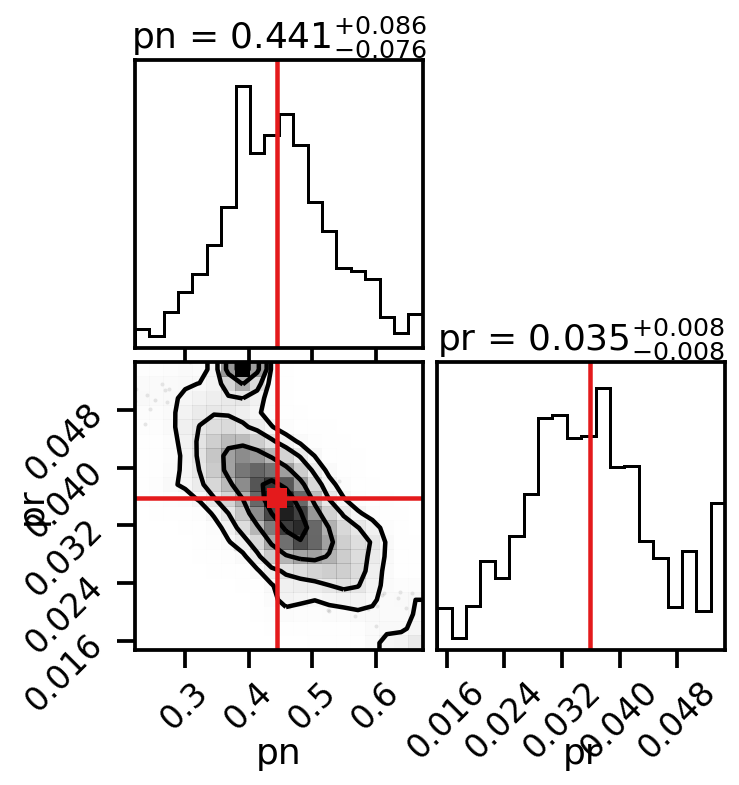

In [68]:
cor = corner(samples, 
    weights=weights,
    title_fmt='.3f', 
    smooth=True,
    show_titles=True,
    truths=(pn_hat, pr_hat),
    truth_color=red,
)

## Posterior distribution convergence

The following shows how the joint posterior converged over the populations of the SMC sampler.

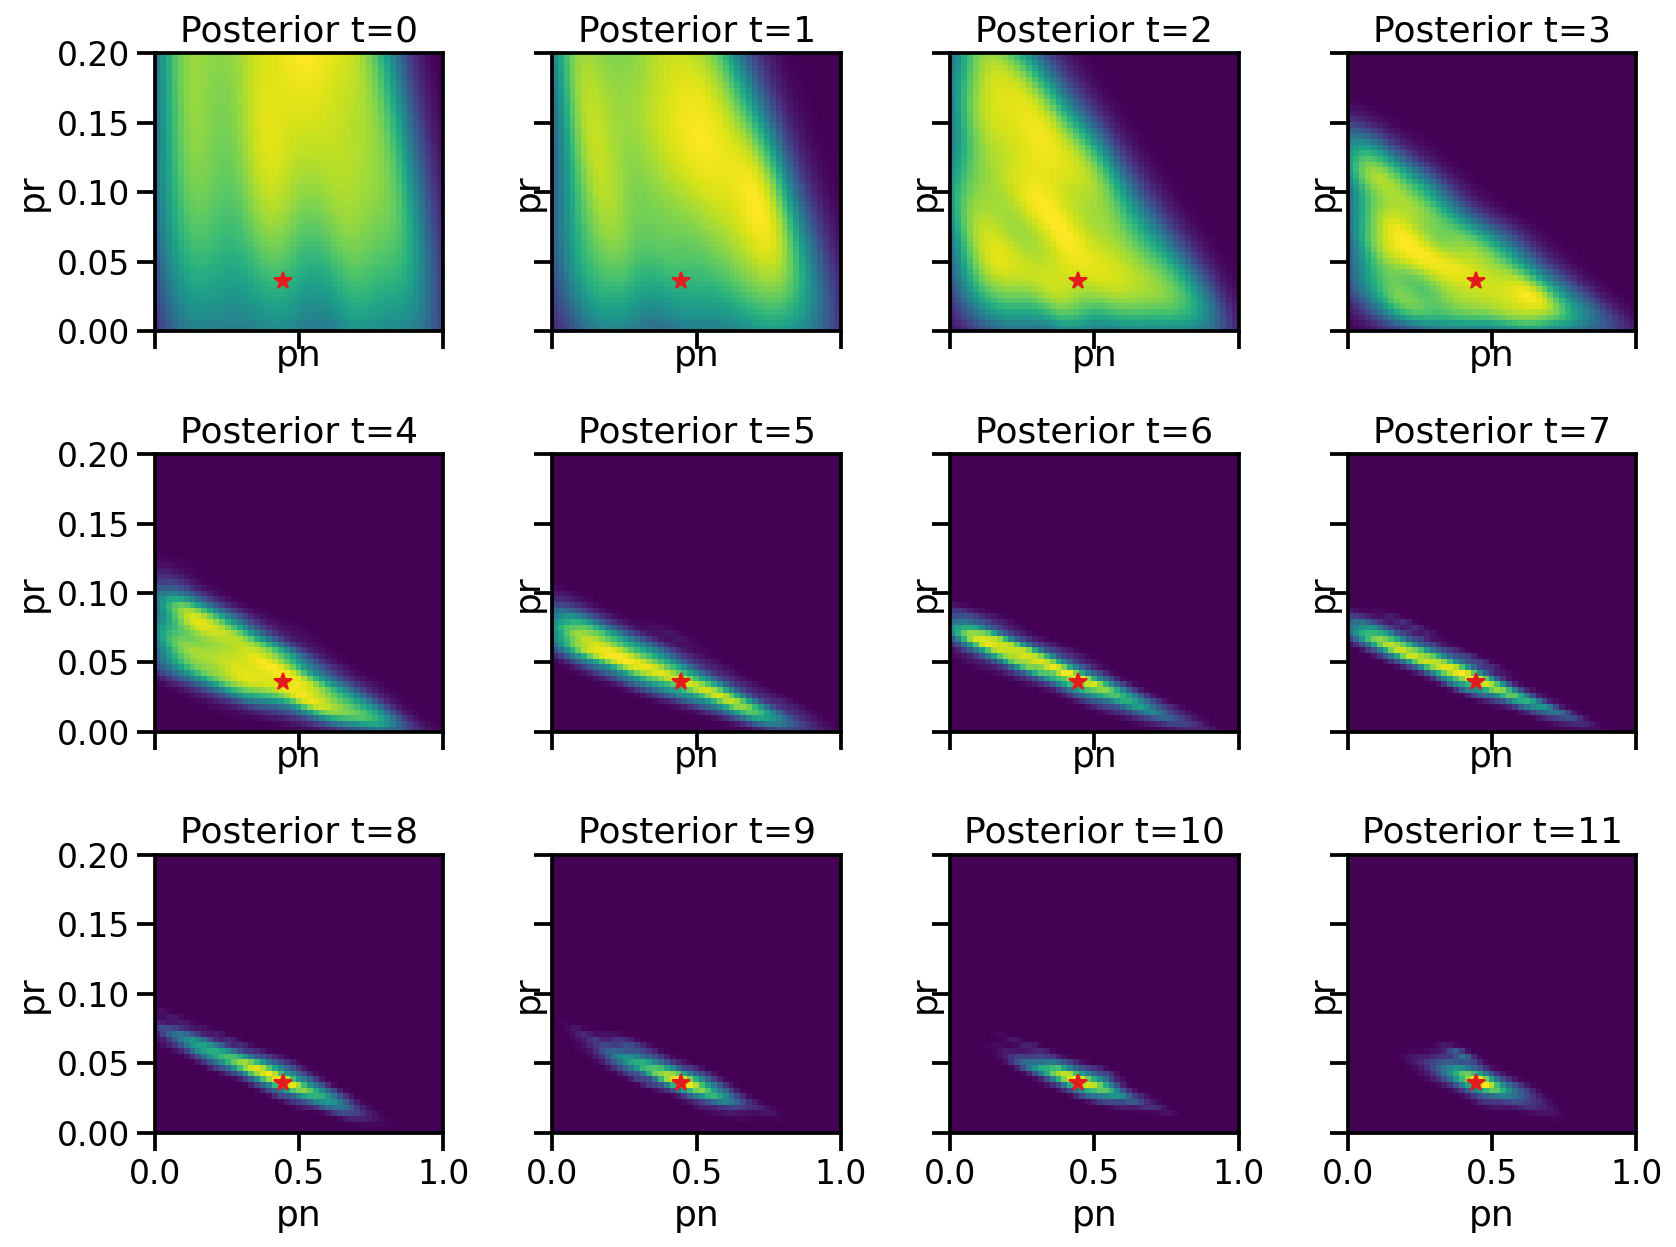

In [69]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
for t in range(history.max_t + 1):
    ax = axes.flat[t]
    samples_, weights_ = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_2d(
        samples_, weights_, "pn", "pr",
        xmin=0, xmax=1, ymin=0, ymax=0.2, colorbar=False, ax=ax)
    ax.plot(pn_hat, pr_hat, '*', color=red)
    ax.set_title("Posterior t={}".format(t))

fig.tight_layout()

## Posterior predictive check

We do a posterior prediction check to see if the posterior predictions for the summary statistics (blue histogram, point estimate in red) are inline with the observations (in black).

The summary statistics using the $p_n$ and $p_r$ estimated using PLS and analytical approximations by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084) (see Table 1) are also drawn, in green.

In [70]:
weights, sum_stats = history.get_weighted_sum_stats()
sum_stats = np.array([list(stat.values()) for stat in sum_stats]).T

In [71]:
pyabc_summary = np.average(sum_stats, weights=weights, axis=1)
print('pyABC: {:.3f}, {:.3f}'.format(*pyabc_summary))

networks = np.array([simulator(0.5, 0.028) for _ in range(100)])
pls_summary = np.mean([mean_degree(net) for net in networks]), np.mean([clustering_coefficient(net) for net in networks])
print('PLS: {:.3f}, {:.3f}'.format(*pls_summary))

networks = np.array([simulator(0.43, 0.036) for _ in range(100)])
analytic_summary = np.mean([mean_degree(net) for net in networks]), np.mean([clustering_coefficient(net) for net in networks])
print('Analytic: {:.3f}, {:.3f}'.format(*analytic_summary))

print('Observed: {:.3f}, {:.3f}'.format(*observation.values()))

pyABC: 5.127, 0.254
PLS: 4.989, 0.287
Analytic: 5.168, 0.245
Observed: 5.129, 0.259


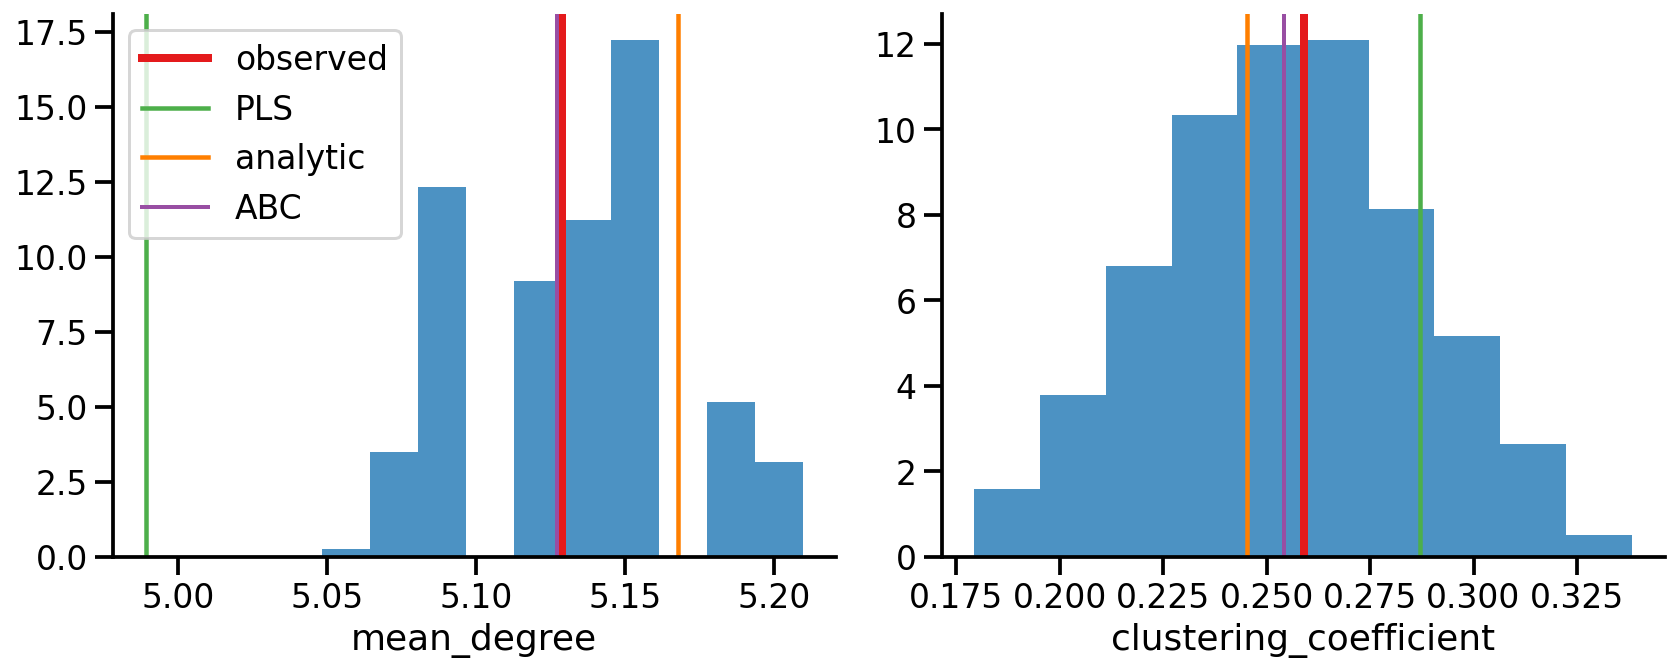

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(sum_stats[0], density=True, alpha=0.8)
axes[0].axvline(observation['mean_degree'], lw=4, color=red, label='observed')
axes[0].axvline(pls_summary[0], color=green, label='PLS') # too far
axes[0].axvline(analytic_summary[0], color=orange, label='analytic')
axes[0].axvline(pyabc_summary[0], lw=2, color=purple, label='ABC')
axes[0].set(xlabel='mean_degree')
axes[0].legend()

axes[1].hist(sum_stats[1], density=True, alpha=0.8)
axes[1].axvline(observation['clustering_coefficient'], lw=4, color=red)
axes[1].axvline(pls_summary[1], color=green)
axes[1].axvline(analytic_summary[1], color=orange)
axes[1].axvline(pyabc_summary[1], lw=2, color=purple)
axes[1].set(xlabel='clustering_coefficient')

fig.tight_layout()
sns.despine()

# References

- [Think Bayes, Bayesian Statistics Made Simple](http://greenteapress.com/wp/think-bayes/) by Allen B. Downey
- [Scott Linderman's notes on ABC](https://casmls.github.io/general/2016/10/02/abc.html)
- [Tanaka et al](http://doi.org/10.1534/genetics.106.055574)' paper on ABC-MCMC analysis of Tubercolosis in San Francisco
- [Sisson et al](http://doi.org/10.1073/pnas.0607208104)'s paper on ABC-SMC

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)